# 0. Introduction
This notebook aims to determine the critical temperature and relative humidity values for calibrating the alarm system of the beehives.<br>
The data set was collected by myself in an [apiary located in Çanakkale, Turkey.](https://www.youtube.com/watch?v=9e4jgN5Z5B4)<br><br>
**Anomaly detection** using neural networks is modeled in an **unsupervised** manner.<br>
**Long Short-Term Memory (LSTM)** neural network model is used to identify anomalies.<br>
LSTM networks are a sub-type of the more general **Recurrent Neural Networks (RNN)**.<br>
The goal is to predict future beehive failures before they happen.

In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.dates import DateFormatter
from matplotlib import rc
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# unhide all rows and columns
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# set random seed
seed(10)
tf.random.set_seed(10)

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Data Loading and Preprocessing

In [2]:
# load hive data 17
df17 = pd.read_csv("../input/beehives/Hive17.csv", delimiter=";", parse_dates=["DateTime"], index_col=["DateTime"])
df17.head()

,T17,RH17,AT17,Tamb,RHamb,ATamb,T17-Tamb,AT17-ATamb
DateTime,,,,,,,,
2021-08-21 14:00:00,32.8,47,36.6,28.8,33,29.1,4.0,7.5
2021-08-21 15:00:00,33.3,46,37.1,28.8,36,29.5,4.5,7.6
2021-08-21 16:00:00,33.5,46,37.4,28.9,35,29.5,4.6,7.9
2021-08-21 17:00:00,33.8,49,38.5,28.5,36,29.1,5.3,9.3
2021-08-21 18:00:00,33.8,51,38.8,27.5,40,28.4,6.3,10.4


In [3]:
# load hive data 85
df85 = pd.read_csv("../input/beehives/Hive85.csv", delimiter=";", parse_dates=["DateTime"], index_col=["DateTime"])
df85.head()

,T85,RH85,AT85,Tamb,RHamb,ATamb,T85-Tamb,AT85-ATamb
DateTime,,,,,,,,
2021-08-21 14:00:00,36.3,78,48.4,28.8,33,29.1,7.5,19.3
2021-08-21 15:00:00,34.9,83,46.7,28.8,36,29.5,6.1,17.1
2021-08-21 16:00:00,34.1,87,45.9,28.9,35,29.5,5.2,16.4
2021-08-21 17:00:00,34.2,89,46.5,28.5,36,29.1,5.7,17.4
2021-08-21 18:00:00,33.9,90,46.2,27.5,40,28.4,6.4,17.8


# 2. Defining Train and Test Data
To define train and test data, the stats of the beehives are checked and stronger beehive is used for training.

In [4]:
df17.describe().round()

,T17,RH17,AT17,Tamb,RHamb,ATamb,T17-Tamb,AT17-ATamb
count,1847.0,1847.0,1847.0,1847.0,1847.0,1847.0,1847.0,1847.0
mean,25.0,67.0,28.0,18.0,68.0,19.0,6.0,9.0
std,7.0,12.0,9.0,6.0,20.0,6.0,4.0,5.0
min,8.0,44.0,6.0,7.0,17.0,6.0,-4.0,-6.0
25%,21.0,58.0,22.0,14.0,53.0,15.0,4.0,6.0
50%,26.0,67.0,29.0,18.0,71.0,18.0,6.0,10.0
75%,30.0,75.0,35.0,22.0,87.0,23.0,9.0,12.0
max,36.0,100.0,48.0,34.0,100.0,36.0,17.0,24.0


In [5]:
df85.describe().round()

,T85,RH85,AT85,Tamb,RHamb,ATamb,T85-Tamb,AT85-ATamb
count,1848.0,1848.0,1848.0,1848.0,1848.0,1848.0,1848.0,1848.0
mean,31.0,66.0,38.0,18.0,68.0,19.0,13.0,19.0
std,3.0,14.0,6.0,6.0,20.0,6.0,4.0,5.0
min,22.0,42.0,24.0,7.0,17.0,6.0,-4.0,5.0
25%,28.0,57.0,32.0,14.0,53.0,15.0,11.0,16.0
50%,33.0,61.0,40.0,18.0,71.0,18.0,14.0,19.0
75%,34.0,69.0,43.0,22.0,87.0,23.0,16.0,22.0
max,38.0,100.0,52.0,34.0,100.0,36.0,24.0,32.0


**Beehive Facts:**<br>
Beehive temperatures usually remains between 21 and 35 Celcius degrees.<br>
During winter times, the hive temperature can go as low as 15 Celcius degrees.<br>
During summer times, the hive temperature can go as high as 36.5 Celcius degrees.<br><br>
Beehive relative humidity usually remains between 50 and 70 percent.<br>
During winter times, the hive relative humidity can go as low as 40 percent.<br>
During summer times, the hive relative humidity can go as high as 100 percent.<br><br>
Hive 85 looks strong, will be used for training.<br>
Hive 17 died in October, will be used for testing.

In [6]:
# define training and testing datasets
print("Training dataset shape:", df85.loc[:].shape)
print("Testing dataset shape:", df17.loc[:].shape)

Training dataset shape: (1848, 8)
Testing dataset shape: (1847, 8)


To review data, plot the sensor readings.

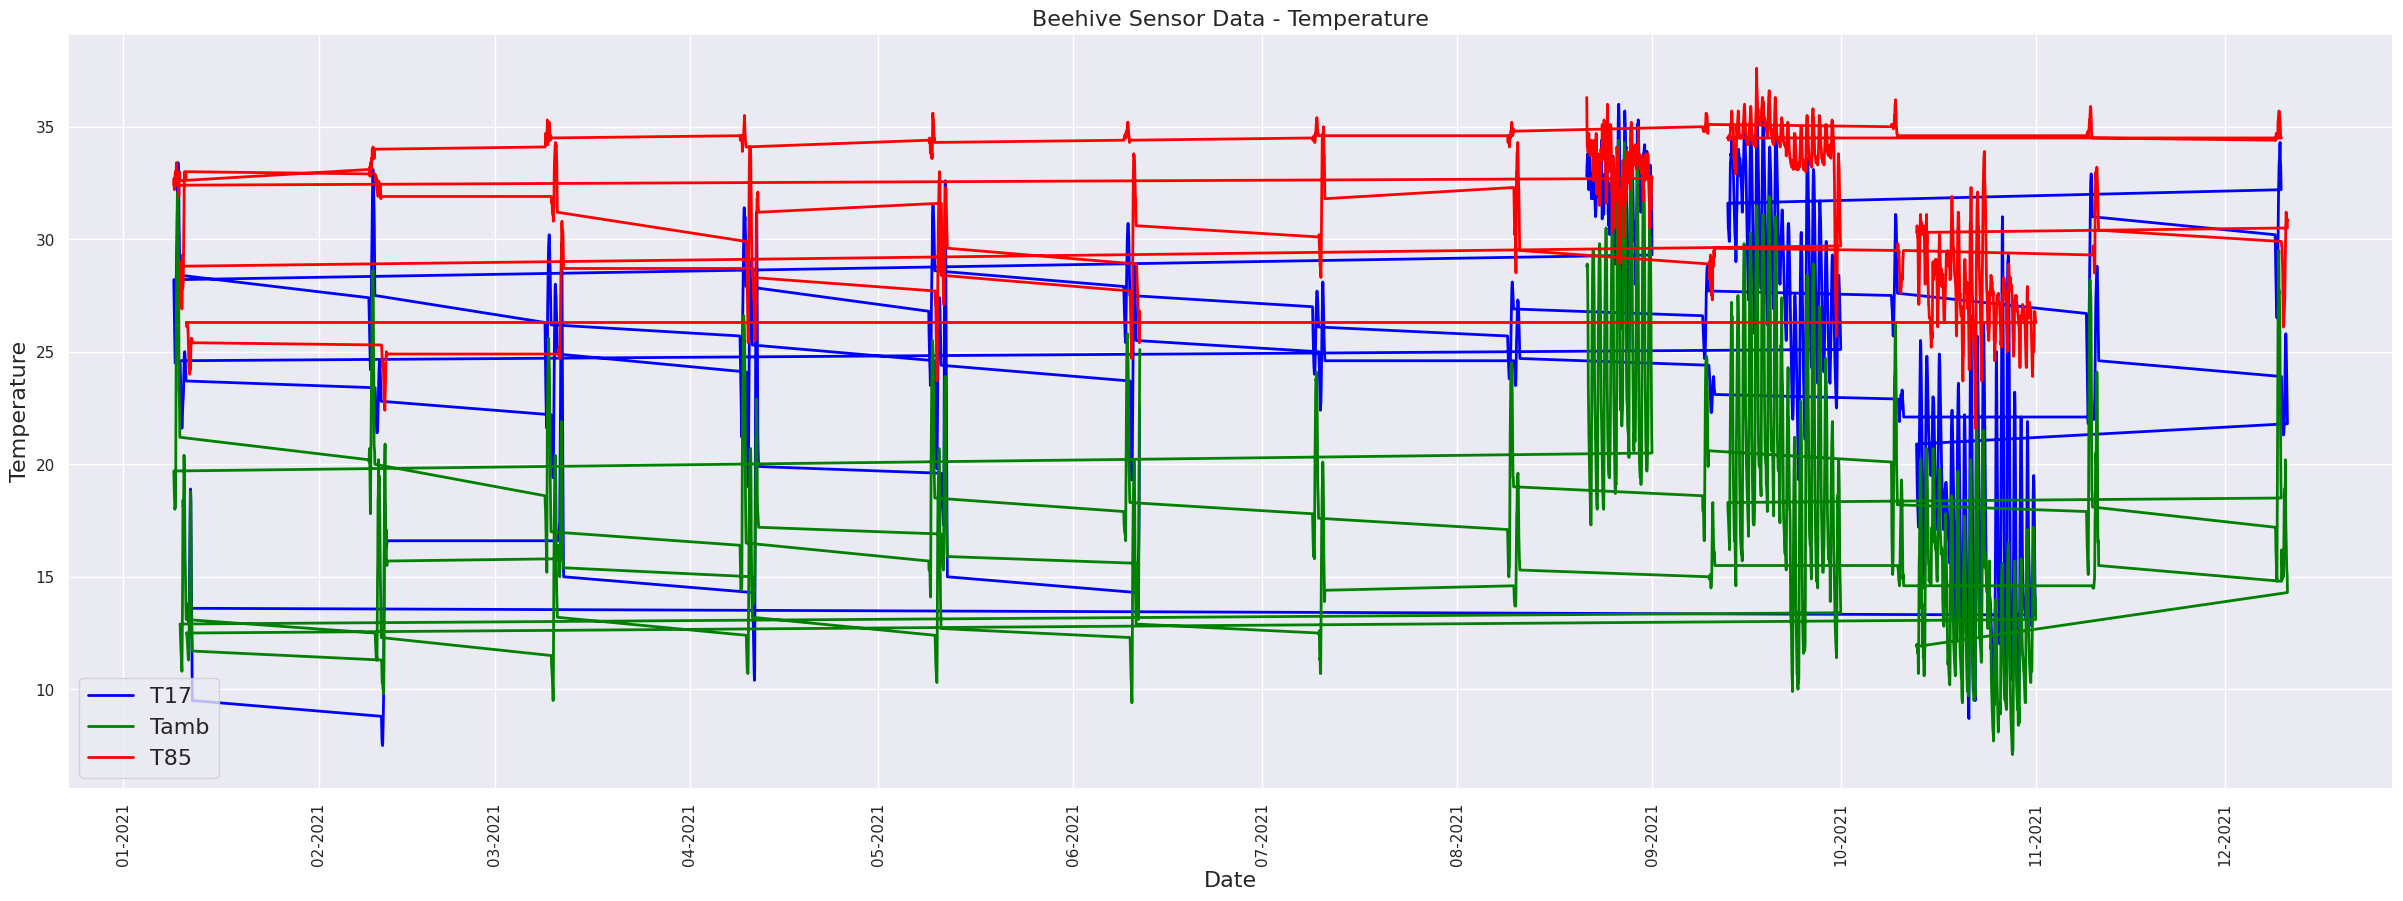

In [7]:
# plot temperature data of the hives
fig, ax = plt.subplots(figsize=(30,10), dpi=100)
ax.plot(df17.index, df17["T17"], label="T17", color="blue", animated = True, linewidth=2)
ax.plot(df85.index, df85["Tamb"], label="Tamb", color="green", animated = True, linewidth=2)
ax.plot(df85.index, df85["T85"], label="T85", color="red", animated = True, linewidth=2)
ax.set_title("Beehive Sensor Data - Temperature", fontsize=16)
ax.xaxis.set_major_locator(md.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(md.DateFormatter("%m-%Y"))
plt.xlabel("Date", fontsize=16)
plt.ylabel("Temperature", fontsize=16)
plt.xticks(rotation=90)
plt.legend(loc="lower left", fontsize=16)
plt.show()

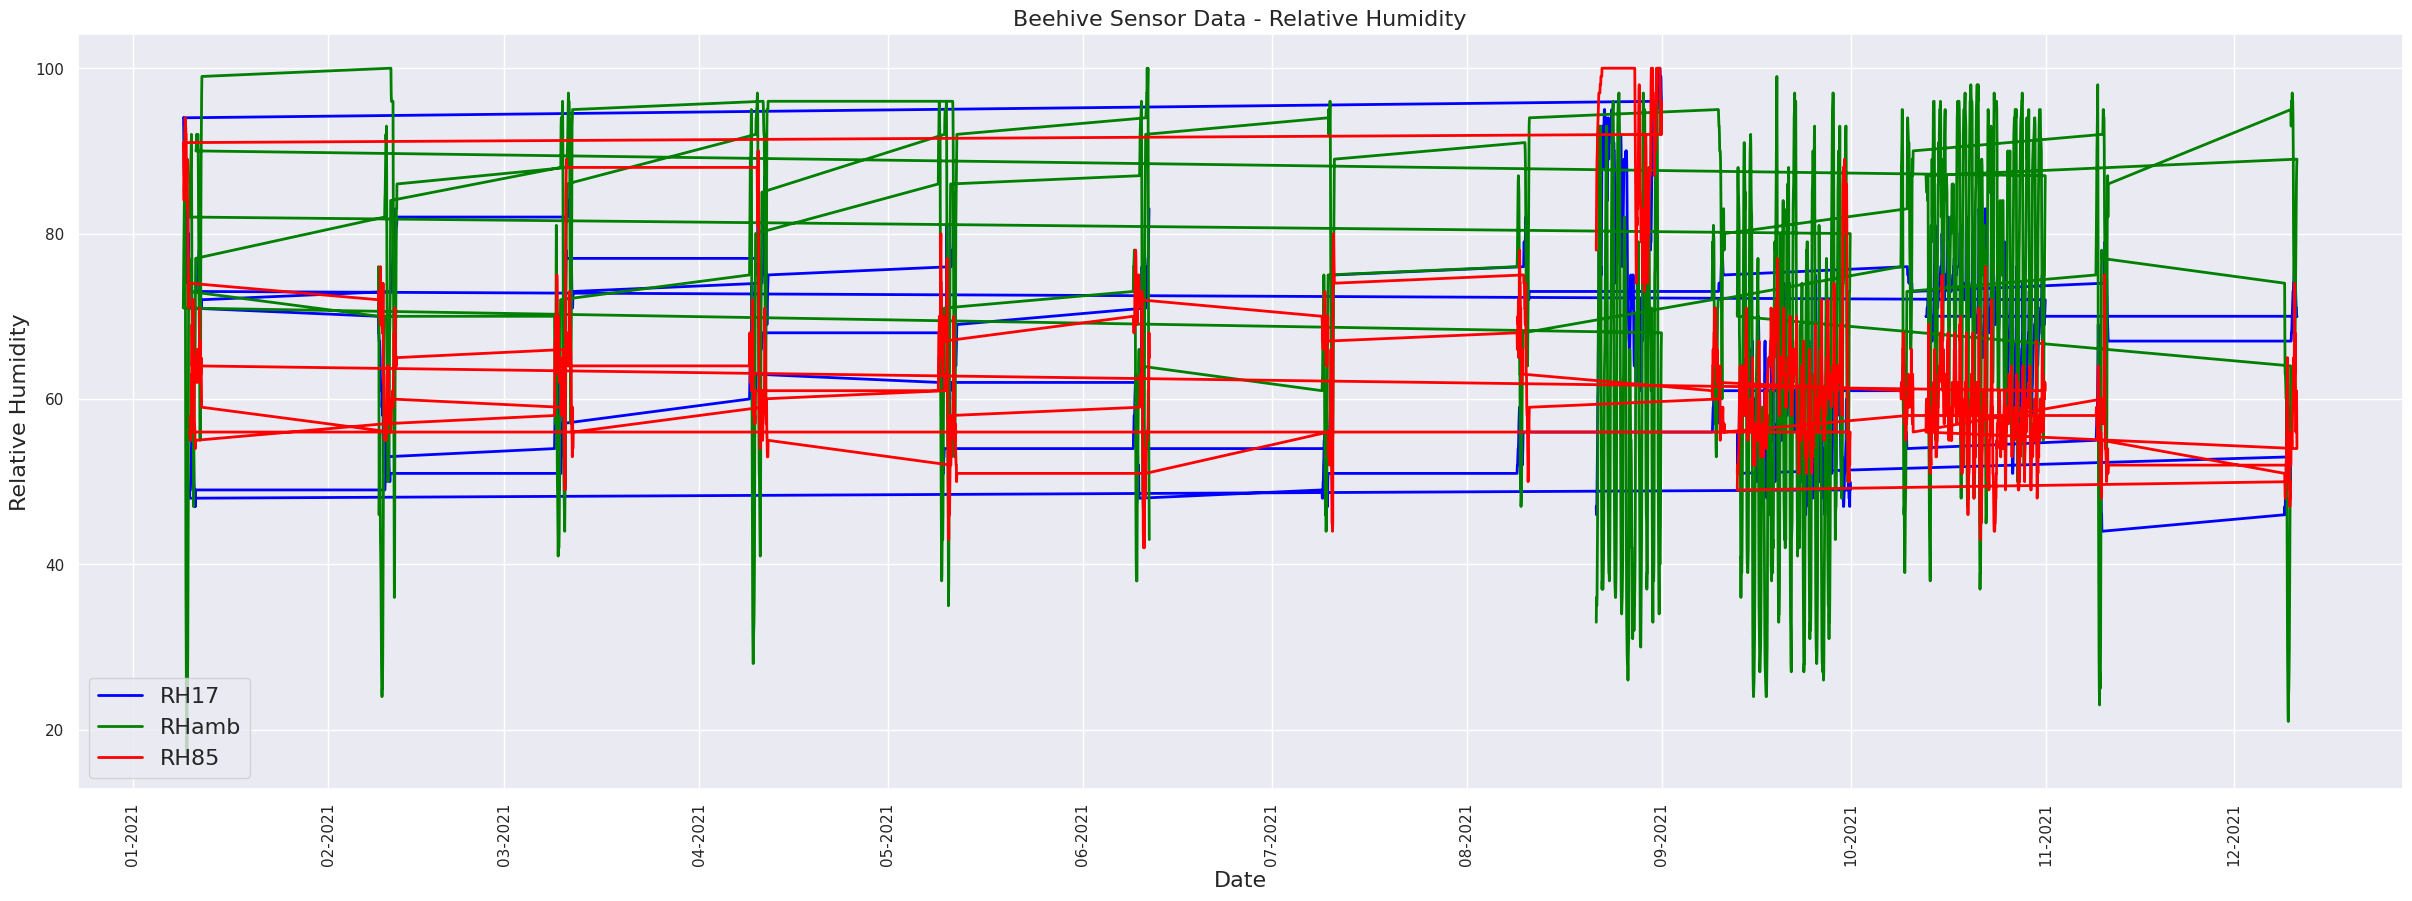

In [8]:
# plot relative humidity data of the hives
fig, ax = plt.subplots(figsize=(30,10), dpi=100)
ax.plot(df17.index, df17["RH17"], label="RH17", color="blue", animated = True, linewidth=2)
ax.plot(df85.index, df85["RHamb"], label="RHamb", color="green", animated = True, linewidth=2)
ax.plot(df85.index, df85["RH85"], label="RH85", color="red", animated = True, linewidth=2)
ax.set_title("Beehive Sensor Data - Relative Humidity", fontsize=16)
ax.xaxis.set_major_locator(md.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(md.DateFormatter("%m-%Y"))
plt.xlabel("Date", fontsize=16)
plt.ylabel("Relative Humidity", fontsize=16)
plt.xticks(rotation=90)
plt.legend(loc="lower left", fontsize=16)
plt.show()

To improve forecasting accuracy of cyclical time series data, the data set will be decomposed as a frequency.<br>
Fast Fourier Transform will be used for decomposing.

In [9]:
# transform data from the time domain to the frequency domain using Fast Fourier Transform
train = df85
test17 = df17

train_fft = np.fft.fft(train)
test17_fft = np.fft.fft(test17)

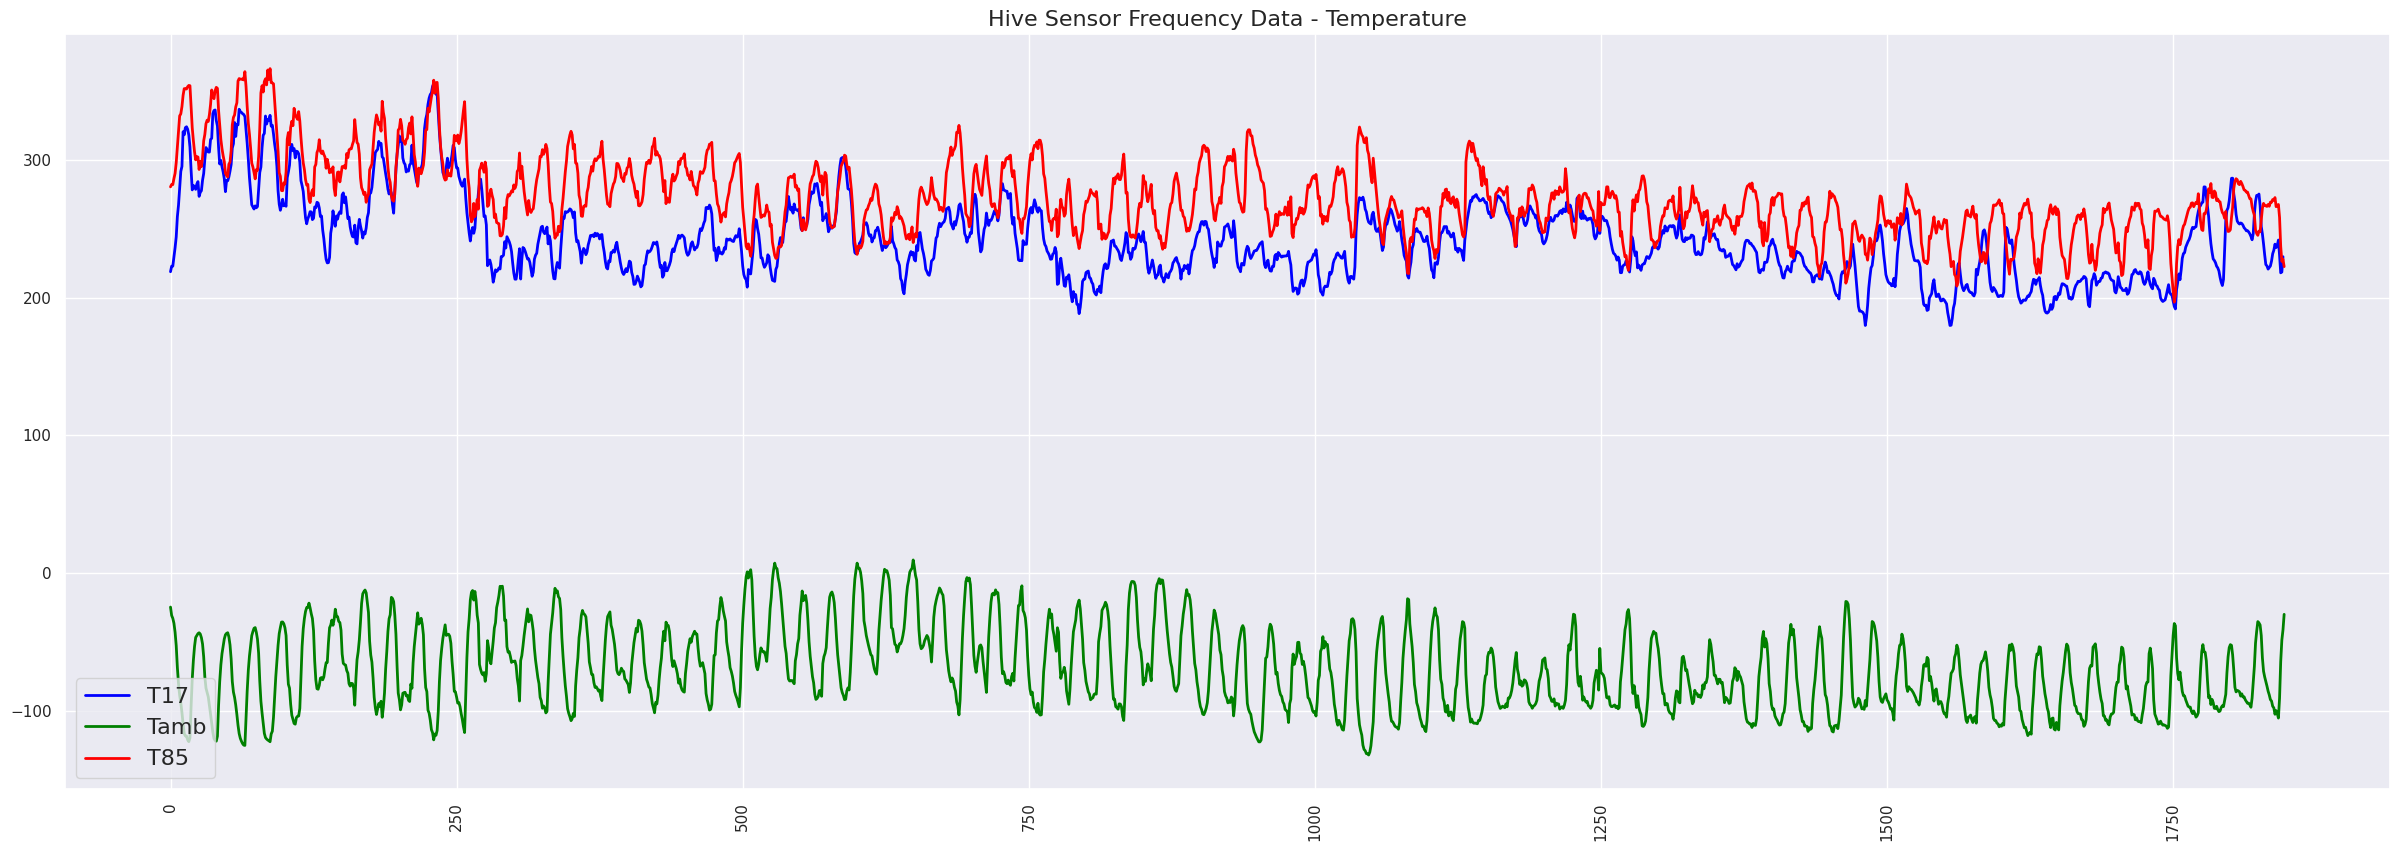

In [10]:
# temperature frequencies of the hives
fig, ax = plt.subplots(figsize=(30,10), dpi=100)
ax.plot(test17_fft[:,0], label="T17", color="blue", animated = True, linewidth=2)
ax.plot(train_fft[:,3], label="Tamb", color="green", animated = True, linewidth=2)
ax.plot(train_fft[:,0], label="T85", color="red", animated = True, linewidth=2)
ax.set_title("Hive Sensor Frequency Data - Temperature", fontsize=16)
#ax.xaxis.set_major_locator(md.MonthLocator(interval=1))
#ax.xaxis.set_major_formatter(md.DateFormatter("%m-%Y"))
#plt.xlabel("Date", fontsize=16)
#plt.ylabel("Temperature", fontsize=16)
plt.xticks(rotation=90)
plt.legend(loc="lower left", fontsize=16)
plt.show()

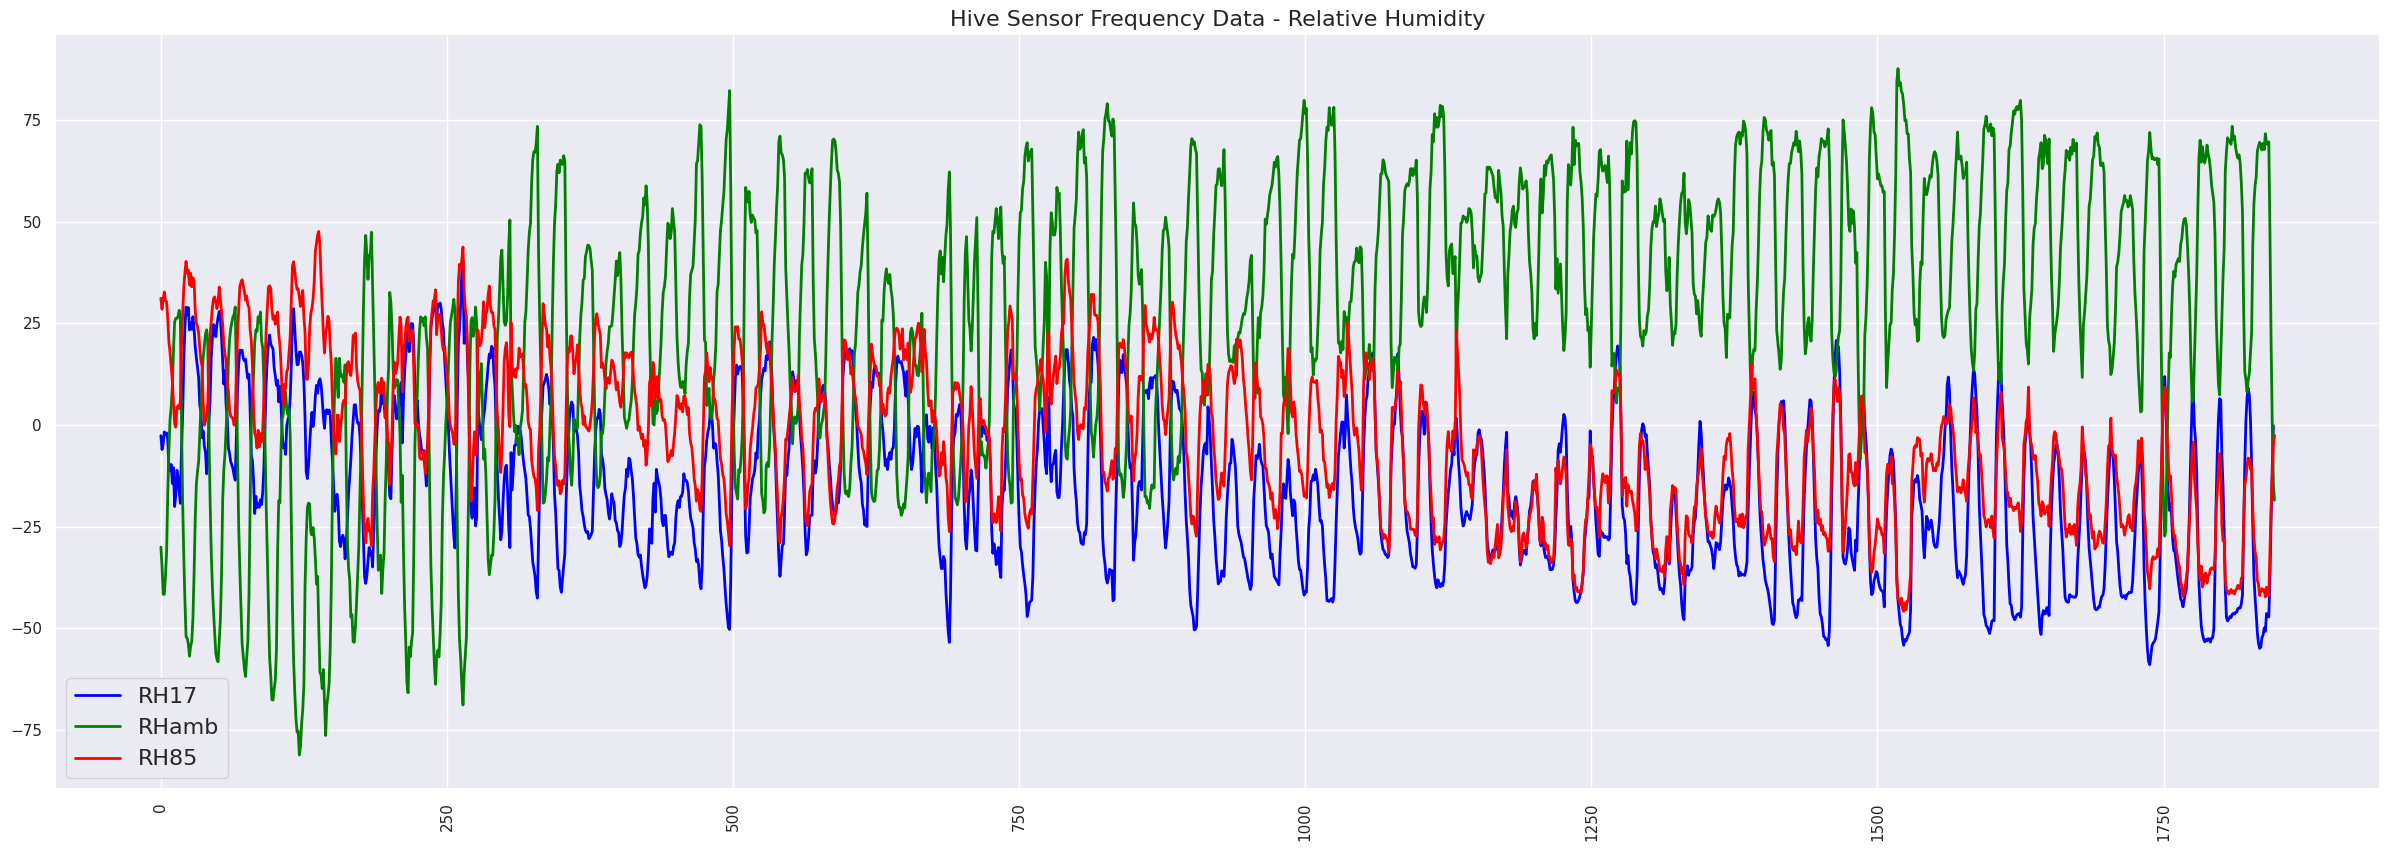

In [11]:
# relative humidity frequencies of the hives
fig, ax = plt.subplots(figsize=(30,10), dpi=100)
ax.plot(test17_fft[:,1], label="RH17", color="blue", animated = True, linewidth=2)
ax.plot(train_fft[:,4], label="RHamb", color="green", animated = True, linewidth=2)
ax.plot(train_fft[:,1], label="RH85", color="red", animated = True, linewidth=2)
ax.set_title("Hive Sensor Frequency Data - Relative Humidity", fontsize=16)
#ax.xaxis.set_major_locator(md.MonthLocator(interval=1))
#ax.xaxis.set_major_formatter(md.DateFormatter("%m-%Y"))
#plt.xlabel("Date", fontsize=16)
#plt.ylabel("Temperature", fontsize=16)
plt.xticks(rotation=90)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [12]:
# normalize the data using Min-Max Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test17 = scaler.transform(test17)

In [13]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test17 = X_test17.reshape(X_test17.shape[0], 1, X_test17.shape[1])
print("Test data shape:", X_test17.shape)

Training data shape: (1848, 1, 8)
Test data shape: (1847, 1, 8)


# 3. Neural Network Model
An autoencoder neural network architecture for this anomaly detection model.<br>
In the LSTM autoencoder network architecture, the first couple of neural network layers create the compressed representation of the input data, the encoder.<br>
Then, a repeat vector layer is used to distribute the compressed representational vector across the time steps of the decoder.<br>
The final output layer of the decoder provides the reconstructed input data.

In [14]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [15]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

2022-02-17 15:06:25.184827: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 8)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 8)              136   

In [16]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

2022-02-17 15:06:25.865610: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
176/176 [==============================] - 9s 11ms/step - loss: 0.3512 - val_loss: 0.1421
Epoch 2/100
176/176 [==============================] - 1s 6ms/step - loss: 0.1466 - val_loss: 0.1380
Epoch 3/100
176/176 [==============================] - 1s 5ms/step - loss: 0.1407 - val_loss: 0.1273
Epoch 4/100
176/176 [==============================] - 1s 5ms/step - loss: 0.1289 - val_loss: 0.1204
Epoch 5/100
176/176 [==============================] - 1s 6ms/step - loss: 0.1187 - val_loss: 0.1136
Epoch 6/100
176/176 [==============================] - 1s 6ms/step - loss: 0.1031 - val_loss: 0.1297
Epoch 7/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0730 - val_loss: 0.1119
Epoch 8/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0640 - val_loss: 0.0958
Epoch 9/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0599 - val_loss: 0.0956
Epoch 10/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0557 - val_l

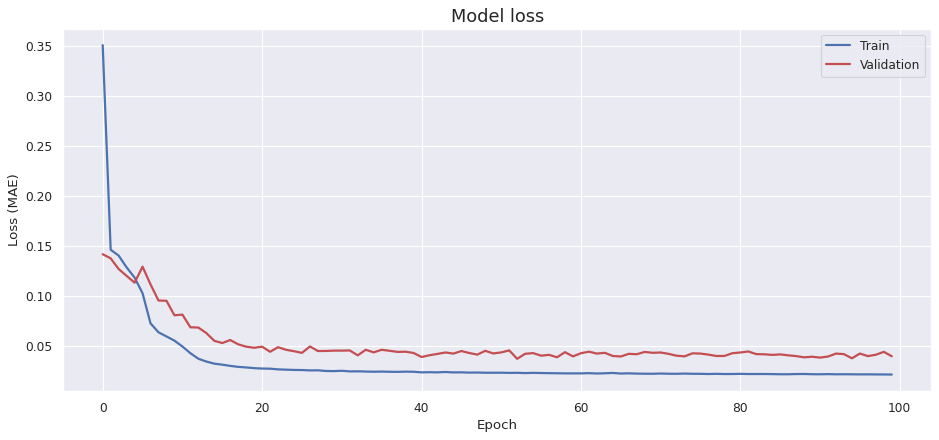

In [17]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# 4. Distribution of Loss
A suitable threshold value for identifting anomalies can be determined by plotting the distribution of the calculated loss in the training set.<br>
It is important to make sure that threshold value is set above the noise level so that false positives are not triggered.

(0.0, 0.1)

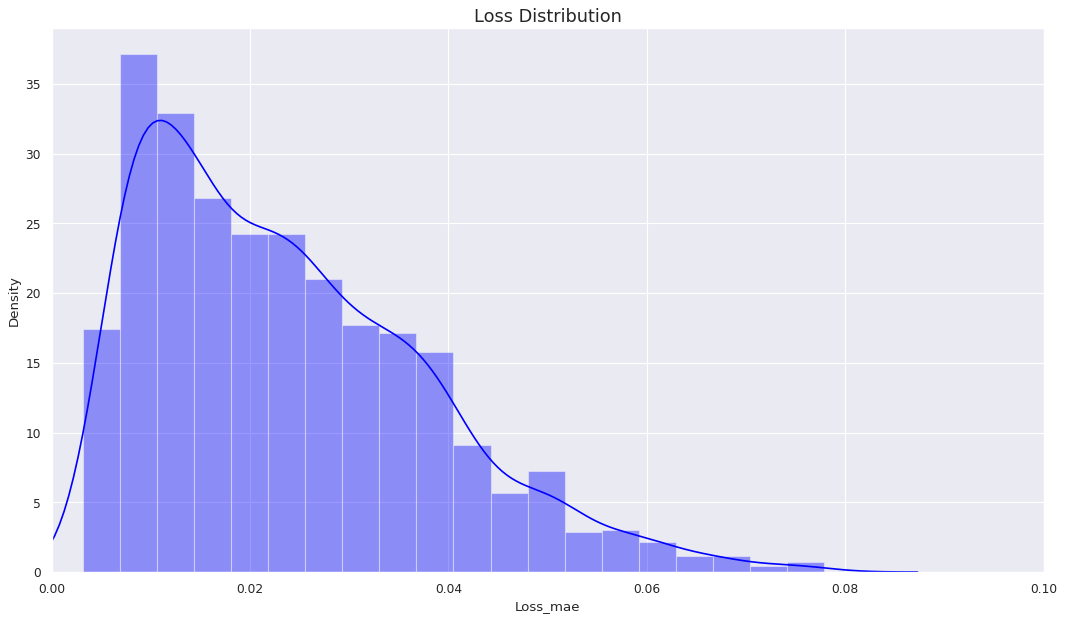

In [18]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.1])

In [19]:
# calculate the loss on the test set
X_pred = model.predict(X_test17)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test17.columns)
X_pred.index = test17.index

scored = pd.DataFrame(index=test17.index)
Xtest17 = X_test17.reshape(X_test17.shape[0], X_test17.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest17), axis = 1)
scored['Threshold'] = 0.079
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']

anomalies = scored[scored.Anomaly == True]
anomalies.head(20)

,Loss_mae,Threshold,Anomaly
DateTime,,,
2021-08-28 09:00:00,0.084168,0.079,True
2021-08-29 00:00:00,0.085270,0.079,True
2021-08-29 01:00:00,0.086216,0.079,True
2021-08-29 02:00:00,0.080960,0.079,True
2021-08-29 03:00:00,0.080195,0.079,True
2021-08-29 07:00:00,0.082525,0.079,True
2021-09-19 06:00:00,0.081189,0.079,True
2021-09-19 07:00:00,0.084637,0.079,True
2021-10-13 07:00:00,0.084032,0.079,True


In [20]:
anomalies.shape

(351, 3)

(array([18628., 18687., 18748., 18809., 18871., 18932.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

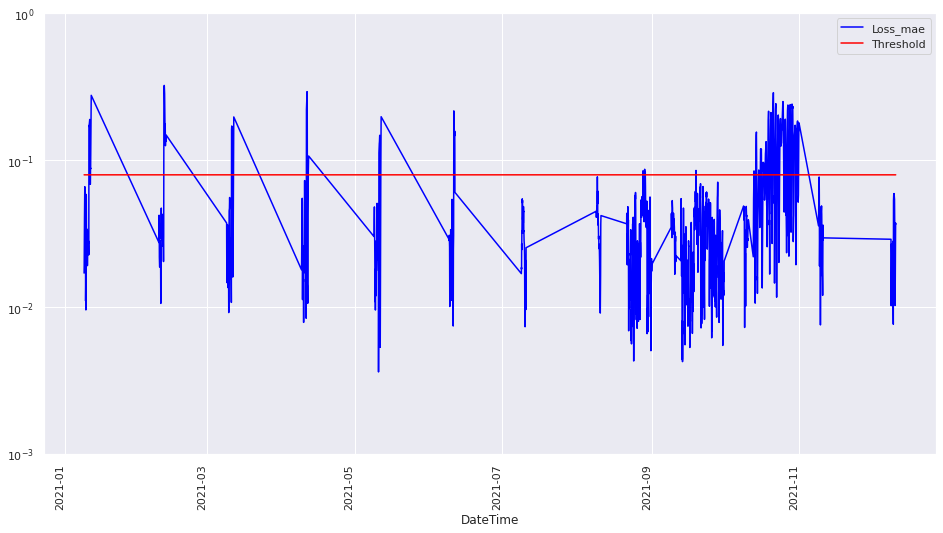

In [21]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-3,1e-0], color=['blue','red'])
plt.xticks(rotation=90)

# 5. Conclusion
The red line indicates the threshold value of 0.079.<br>

**This notebook will be updated in parallel with [the dataset.](https://www.kaggle.com/vivovinco/beehives)**